# Cars 196 - Multi Class Classification

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
import keras
import os, sys
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import numpy as np

# Define train data
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
train_images_dir = os.path.join('./', 'cars_train')
train_labels_mat = scipy.io.loadmat('cars_train_annos.mat')
train_labels_data = [[row.flat[0] for row in line] for line in train_labels_mat['annotations'][0]]
df_train = pd.DataFrame(train_labels_data, columns=columns)
print("\n================================\nTrain Data\n================================\n", df_train)

# Define test data
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
test_images_dir = os.path.join('./', 'cars_test')
test_labels_mat = scipy.io.loadmat('cars_test_annos.mat')
test_labels_data = [[row.flat[0] for row in line] for line in test_labels_mat['annotations'][0]]
df_test = pd.DataFrame(test_labels_data, columns=columns) 
print("\n================================\nTest Data\n================================\n", df_test)

Using TensorFlow backend.



Train Data
       bbox_x1  bbox_y1  bbox_x2  bbox_y2  class      fname
0          39      116      569      375     14  00001.jpg
1          36      116      868      587      3  00002.jpg
2          85      109      601      381     91  00003.jpg
3         621      393     1484     1096    134  00004.jpg
4          14       36      133       99    106  00005.jpg
...       ...      ...      ...      ...    ...        ...
8139        3       44      423      336     78  08140.jpg
8140      138      150      706      523    196  08141.jpg
8141       26      246      660      449    163  08142.jpg
8142       78      526     1489      908    112  08143.jpg
8143       20      240      862      677     17  08144.jpg

[8144 rows x 6 columns]

Test Data
       bbox_x1  bbox_y1  bbox_x2  bbox_y2      fname
0          30       52      246      147  00001.jpg
1         100       19      576      203  00002.jpg
2          51      105      968      659  00003.jpg
3          67       84      581   

In [2]:
count = 0

class_names = [item for item in df_train['class']]
class_filenames = [item for item in df_train['fname']]

# Generate the folder structure
# for directory in range(1, 197):
#    path = './cars_train/' + str(directory)
#    os.mkdir(path, 755)
#    path2 = './cars_test/' + str(directory)
#    os.mkdir(path2, 755)


# for name in class_filenames:
#     if count < 100:
#         old_path = "./cars_train/" + name
#         new_path = "./cars_test/" + str(class_names[count]) + "/" + name
#     else:
#         old_path = "./cars_train/" + name
#         new_path = "./cars_train/" + str(class_names[count]) + "/" + name
    
#     os.rename(old_path, new_path)
#     count += 1


In [3]:
# Try out CNN
batch_size = 32
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Rescale the images
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Run images through the image generators
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_images_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           shuffle=True,
                                                           class_mode='categorical')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                             directory=test_images_dir,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='categorical')



Found 8044 images belonging to 196 classes.
Found 100 images belonging to 196 classes.


## Look at them images

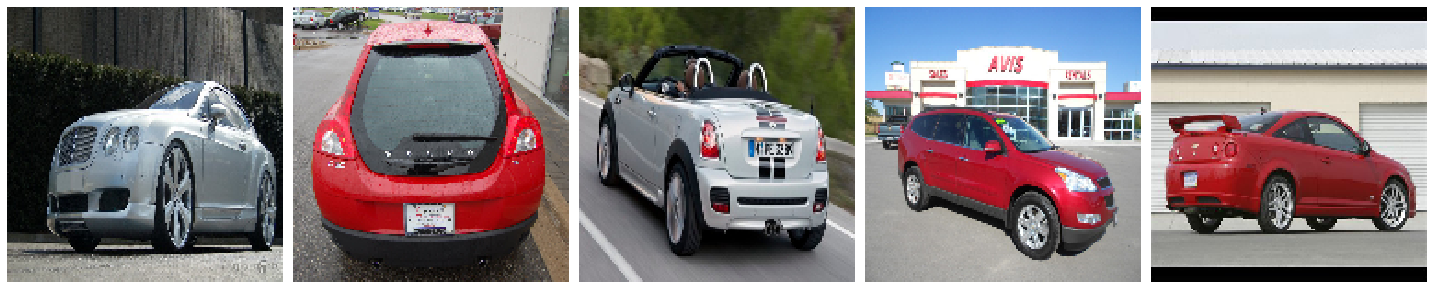

In [4]:
# Visualize training images
sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

## Define keras model

In [5]:
# It's sequential with 3 Convolutional layers and two dense layers.
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(196, activation='softmax')
])



In [7]:
# Complile model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# View all of the layers of the network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

## Log the results with tensorboard

In [6]:
logger = keras.callbacks.TensorBoard(log_dir="logs", write_graph=True, histogram_freq=5)

## Train le model

In [8]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=8044 // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=100 // batch_size,
    callbacks=[logger]
)

Epoch 1/15
251/251 [==============================] - 32s 129ms/step - loss: 5.2825 - accuracy: 0.0061 - val_loss: 5.2744 - val_accuracy: 0.0104
Epoch 2/15
251/251 [==============================] - 32s 128ms/step - loss: 5.2038 - accuracy: 0.0156 - val_loss: 5.3218 - val_accuracy: 0.0208
Epoch 3/15
251/251 [==============================] - 32s 128ms/step - loss: 4.0153 - accuracy: 0.1784 - val_loss: 6.0849 - val_accuracy: 0.0312
Epoch 4/15
251/251 [==============================] - 31s 125ms/step - loss: 1.2316 - accuracy: 0.7292 - val_loss: 9.5196 - val_accuracy: 0.0312
Epoch 5/15
251/251 [==============================] - 31s 125ms/step - loss: 0.2080 - accuracy: 0.9624 - val_loss: 12.3303 - val_accuracy: 0.0208
Epoch 6/15
251/251 [==============================] - 32s 126ms/step - loss: 0.1051 - accuracy: 0.9863 - val_loss: 11.9388 - val_accuracy: 0.0312
Epoch 7/15
251/251 [==============================] - 31s 125ms/step - loss: 0.0845 - accuracy: 0.9888 - val_loss: 12.1400 - val